# 1D convolution

Pytorch Conv1d is versatible. For convienence, I define a wrapper over Conv1d:

1. I assume **stride = 1** for Conv1D layer. 

2. Add padding so that input tensor and output tensors have the **same length**. Furthermore:
    * For causal convolution, I need to pad the data sequence on the left side
    * For non-causal convoltuion, I pad on both sizes of a data sequence
    
   Since stride = 1, the total padding size should be equal to dilation_s * (kernel_s - 1)

3. Pytorch conv1d operates along the last dimension a tensor. I need a **conv1d that operates along the second dimension of the inpute tensor (batchsize, length, dim)**;

4. Following the conventions in NSF models, I need to add **tanh()** right after conv1d;


### 1. Module definition 

In [1]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

class Conv1dKeepLength(torch_nn.Conv1d):
    """ Wrapper for causal convolution
    Input tensor:  (batchsize, length, dim_in)
    Output tensor: (batchsize, length, dim_out)
    
    Implemented based on:
    https://github.com/pytorch/pytorch/issues/1333
    
    Define:
        see __init__ below
        
    """
    def __init__(self, input_dim, output_dim, dilation_s, kernel_s, 
                 causal = False, stride = 1, groups=1, bias=True, \
                 tanh = True, pad_mode='constant'):
        super(Conv1dKeepLength, self).__init__(
            input_dim, output_dim, kernel_s, stride=1,
            padding = 0, dilation = dilation_s, groups=groups, bias=bias)

        self.pad_mode = pad_mode
        self.causal = causal
        
        # padding size
        # input & output length will be the same
        if self.causal:
            # left pad to make the convolution causal
            self.pad_le = dilation_s * (kernel_s - 1)
            self.pad_ri = 0
        else:
            # pad on both sizes
            self.pad_le = dilation_s * (kernel_s - 1) // 2
            self.pad_ri = dilation_s * (kernel_s - 1) - self.pad_le
    
        # activation functions
        if tanh:
            self.l_ac = torch_nn.Tanh()
        else:
            self.l_ac = torch_nn.Identity()
        
    def forward(self, data):
        # https://github.com/pytorch/pytorch/issues/1333
        # permute to (batchsize=1, dim, length)
        # add one dimension as (batchsize=1, dim, ADDED_DIM, length)
        # pad to ADDED_DIM
        # squeeze and return to (batchsize=1, dim, length+pad_length)
        x = torch_nn_func.pad(data.permute(0, 2, 1).unsqueeze(2), \
                              (self.pad_le, self.pad_ri,0,0), \
                              mode = self.pad_mode).squeeze(2)
        # tanh(conv1())
        # permmute back to (batchsize=1, length, dim)
        output = self.l_ac(super(Conv1dKeepLength, self).forward(x))
        return output.permute(0, 2, 1)

(<Figure size 151.2x187.2 with 2 Axes>,
  <matplotlib.axes._axes.Axes at 0x7fca75e92880>])

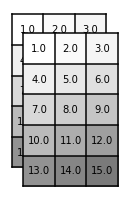

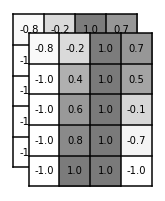

In [7]:
# Try one sample

# some configurations
data = torch.zeros([2, 5, 3])
data[0] = torch.tensor([[1,2,3], [4,5,6], [7,8,9], [10,11,12],[13,14,15]])
data[1] = torch.tensor([[1,2,3], [4,5,6], [7,8,9], [10,11,12],[13,14,15]])

batch_size = data.shape[0]
frame_length = data.shape[1]
input_feature_dim = data.shape[2]
output_feature_dim = 4
kernel_size = 3
dilation_size = 1
with torch.no_grad():
    # create input data
    input_data = data
    
    # create a conv1d layer (non-causal, dilation 1, kernel_s 2)
    l_conv1d = Conv1dKeepLength(input_feature_dim, output_feature_dim, dilation_s=dilation_size, kernel_s=kernel_size)
    
    # compute output data
    output_data = l_conv1d(input_data)

import plot_lib
# input tensor
plot_lib.plot_tensor(data, color_on_value=True)

# output tensor
plot_lib.plot_tensor(output_data, color_on_value=True)


### 2. Look inside Module

The case above: kernel_soze = 3, dilation_size = 1, non-causal

(<Figure size 151.2x187.2 with 2 Axes>,
  <matplotlib.axes._axes.Axes at 0x7fca7a568490>])

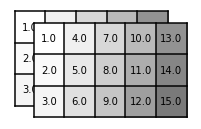

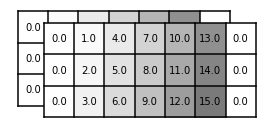

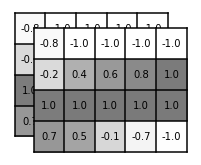

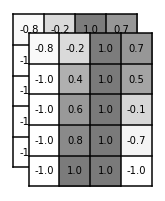

In [11]:
#
# step1. permute
x = data.permute(0, 2, 1)
plot_lib.plot_tensor(x, color_on_value=True)

# step2. padding
# For non-casual CNN, we pad on both left and right side
pad_le = dilation_size * (kernel_size - 1) // 2
pad_ri = dilation_size * (kernel_size - 1) - pad_le

x = torch_nn_func.pad(x.unsqueeze(2), (pad_le, pad_ri,0,0), mode = 'constant').squeeze(2)
plot_lib.plot_tensor(x, color_on_value=True)

# step3. convolution
with torch.no_grad():
    y = l_conv1d.l_ac(super(Conv1dKeepLength, l_conv1d).forward(x))
plot_lib.plot_tensor(y, color_on_value=True)

# step4. permute back
y = y.permute(0, 2, 1)
plot_lib.plot_tensor(y, color_on_value=True)

How about the case when using causal convolution? 

We just need to pad on one side

(<Figure size 151.2x187.2 with 2 Axes>,
  <matplotlib.axes._axes.Axes at 0x7fca79377220>])

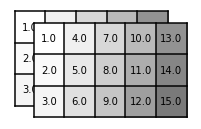

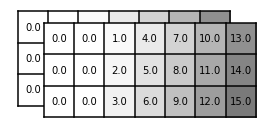

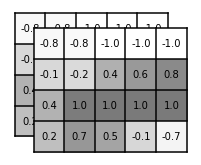

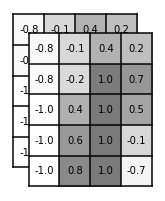

In [12]:
#
# step1. permute
x = data.permute(0, 2, 1)
plot_lib.plot_tensor(x, color_on_value=True)

# step2. padding
# For non-casual CNN, we pad on both left and right side
pad_le = dilation_size * (kernel_size - 1)
pad_ri = 0

x = torch_nn_func.pad(x.unsqueeze(2), (pad_le, pad_ri,0,0), mode = 'constant').squeeze(2)
plot_lib.plot_tensor(x, color_on_value=True)

# step3. convolution
with torch.no_grad():
    y = l_conv1d.l_ac(super(Conv1dKeepLength, l_conv1d).forward(x))
plot_lib.plot_tensor(y, color_on_value=True)

# step4. permute back
y = y.permute(0, 2, 1)
plot_lib.plot_tensor(y, color_on_value=True)

## Some explanation about padding

I used torch.nn.functional.pad to pad the data sequence. The Pytorch doc is not easy to understand, and I try to explain it here with examples

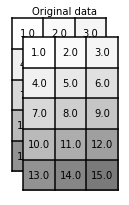

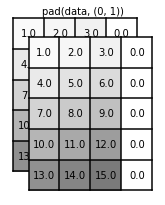

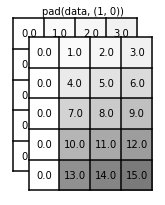

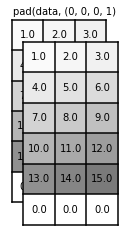

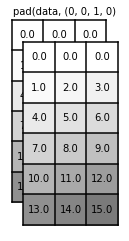

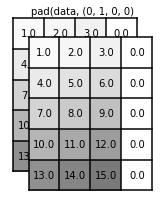

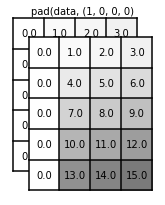

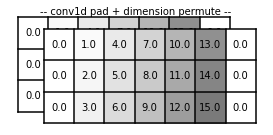

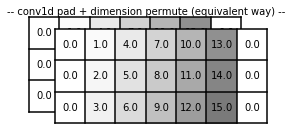

In [19]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

# Let's try pad in different configurations
pad_size = 1
data = torch.zeros([2, 5, 3])
data[0] = torch.tensor([[1,2,3], [4,5,6], [7,8,9], [10,11,12],[13,14,15]])
data[1] = torch.tensor([[1,2,3], [4,5,6], [7,8,9], [10,11,12],[13,14,15]])


import plot_lib
def show_data(data, message):
    
    fig, axis = plot_lib.plot_tensor(data, color_on_value=True)
    fig.text(0.5, 0.98, message, ha='center') 

# original data
show_data(data, 'Original data')

# try padding in different configs
data2 = torch_nn_func.pad(data, (0, pad_size))
show_data(data2, 'pad(data, (0, 1))')

data2 = torch_nn_func.pad(data, (pad_size, 0))
show_data(data2, 'pad(data, (1, 0))')

data2 = torch_nn_func.pad(data, (0, 0, 0, pad_size))
show_data(data2, 'pad(data, (0, 0, 0, 1)')

data2 = torch_nn_func.pad(data, (0, 0, pad_size, 0))
show_data(data2, 'pad(data, (0, 0, 1, 0)')

data2 = torch_nn_func.pad(data, (0, pad_size, 0, 0))
show_data(data2, 'pad(data, (0, 1, 0, 0)')

data2 = torch_nn_func.pad(data, (pad_size, 0, 0, 0))
show_data(data2, 'pad(data, (1, 0, 0, 0)')

# Try the padding method used in Conv1DKeepLength
# 1. permute(0, 2, 1): transposes the data from (batchsize, length, dim) to (batchsize, dim, length)
# 2. pad: pad the tensor to (batchsize, dim, length + pad_length)
data2 = torch_nn_func.pad(data.permute(0, 2, 1), (pad_size, pad_size))
show_data(data2, '-- conv1d pad + dimension permute -- ')

# here is an equivalent way
data2 = torch_nn_func.pad(data.permute(0, 2, 1).unsqueeze(2), (pad_size, pad_size,0,0)).squeeze(2)
show_data(data2, '-- conv1d pad + dimension permute (equivalent way) -- ')

#### The end
We can define other modules based on conv1d, e.g., moving average, time-invairnt filtering.

Please check the following tutorial slides